# EMG Data Exploration

In this notebook we explore the sEMG dataset for different hand gestures. We perform the following steps:

* Preprocess and clean up our dataset
* Leverage signal processing to smooth out the dataset
* Perform a variety of classification techniques

In [218]:
import random

import numpy as np
import pandas as pd

import scipy.io
import scipy
from scipy import signal

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.cluster import KMeans

In [239]:
""" Define schema of datasets
"""

DATABASE = {
    'Database 1': ['female_1',
                  'female_2',
                  'female_3',
                  'male_1',
                  'male_2'],
    'Database 2': ['male_day_1',
                  'male_day_2',
                  'male_day_3']
}

COLUMNS = ['cyl_ch1', 
            'cyl_ch2', 
            'hook_ch1', 
            'hook_ch2', 
            'tip_ch1', 
            'tip_ch2', 
            'palm_ch1', 
            'palm_ch2', 
            'spher_ch1', 
            'spher_ch2', 
            'lat_ch1', 
            'lat_ch2']

LABELS = [
    'Spherical',
    'Tip',
    'Palmar',
    'Lateral',
    'Cylindrical',
    'Hook'
]

COL_MAPPINGS = {
            'cyl_ch1': 'Cylindrical', 
            'cyl_ch2': 'Cylindrical', 
            'hook_ch1': 'Hook', 
            'hook_ch2': 'Hook', 
            'tip_ch1': 'Tip', 
            'tip_ch2': 'Tip', 
            'palm_ch1': 'Palmar', 
            'palm_ch2': 'Palmar', 
            'spher_ch1': 'Spherical', 
            'spher_ch2': 'Spherical', 
            'lat_ch1': 'Lateral', 
            'lat_ch2': 'Lateral'
}

In [240]:
""" Preprocess and standardize dataset into a single dataframe table
"""

DB_NAME = 'Database 1'
dfs = []
for fname in DATABASE[DB_NAME]: 
    tmp_data = scipy.io.loadmat(f'./data/{DB_NAME}/{fname}')
    tmp_data = {k:v for k,v in tmp_data.items() if k in COLUMNS}
    for c in COLUMNS:
        tmp_dfx = pd.DataFrame(tmp_data[c])
        tmp_dfx['identifier'] = fname
        tmp_dfx['label'] = COL_MAPPINGS[c]
        dfs.append(pd.DataFrame(tmp_dfx))

dataset = pd.concat(dfs)
print("Dimensions", dataset.shape)
dataset.head()

Dimensions (1800, 3002)


,0,1,2,3,4,5,6,7,8,9,...,2992,2993,2994,2995,2996,2997,2998,2999,identifier,label
0,0.072198,0.276211,0.429221,0.327214,0.123201,0.097700,0.072198,0.021195,-0.004307,0.174205,...,0.276211,-0.259323,0.072198,1.882814,0.480224,-2.528968,0.097700,0.837247,female_1,Cylindrical
1,0.250710,0.301713,0.199706,0.378218,0.021195,-0.080812,-0.106313,0.021195,0.276211,0.072198,...,-1.304890,0.786244,0.786244,0.939254,1.270775,-0.616346,0.454723,0.021195,female_1,Cylindrical
2,0.123201,0.148703,0.148703,0.123201,-0.004307,-0.157317,-0.029808,0.174205,0.199706,0.250710,...,-0.233821,0.403719,0.046696,-0.080812,0.378218,-0.361330,0.505726,0.607732,female_1,Cylindrical
3,0.531228,-0.106313,-0.284825,-0.335828,-0.182818,0.123201,0.301713,0.352716,0.327214,-0.029808,...,0.709739,0.276211,-0.080812,0.123201,0.735241,1.270775,-0.769356,-1.687415,female_1,Cylindrical
4,-0.310326,-0.182818,0.276211,0.480224,0.352716,0.123201,0.123201,0.097700,-0.029808,-0.080812,...,-0.208320,0.429221,0.378218,0.633234,0.811746,0.403719,-0.182818,-0.412333,female_1,Cylindrical


In [241]:
dx = scipy.io.loadmat('./data/Database 2/male_day_1.mat')
dx.keys()

dict_keys(['__header__', '__version__', '__globals__', 'cyl_ch1', 'cyl_ch2', 'hook_ch1', 'hook_ch2', 'tip_ch1', 'tip_ch2', 'palm_ch1', 'palm_ch2', 'spher_ch1', 'spher_ch2', 'lat_ch1', 'lat_ch2'])

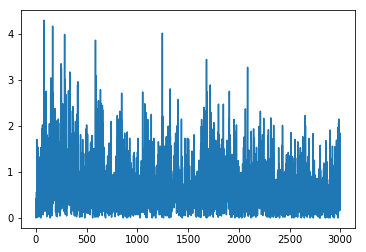

In [159]:
""" Apply absolute value filter to set all values >0
"""
emg_abs = abs(hook_df)
plt.plot((emg_abs.to_numpy()[5,:]))

In [250]:
def abs_val_filter(data):
    """ Apply an absolute value filter to a DataFrame
    """
    return abs(data.copy())

def butterworth_low_pass_filter(data, 
                                frequency=500, 
                                lp_filter=5,
                                order=4):
    """
    Create a low pass filter to eliminate noise and smooth EMG data 
    
    The data were collected at a sampling rate of 500 Hz, 
    using as a programming kernel the National Instruments (NI) Labview. 
    The signals were band-pass filtered using a Butterworth Band Pass filter 
    with low and high cutoff at 15Hz and 500Hz respectively and a notch filter at 50Hz 
    to eliminate line interference artifacts.
    """
    lp_filter = lp_filter/(frequency/2)

    # Create a lowpass butterworth signal 
    B, A = scipy.signal.butter(order, 
                               lp_filter, 
                               btype='lowpass')

    # Apply the lowpass signal filter to EMG data
    smooth_emg = scipy.signal.filtfilt(B, 
                                       A, 
                                       data)
    return smooth_emg

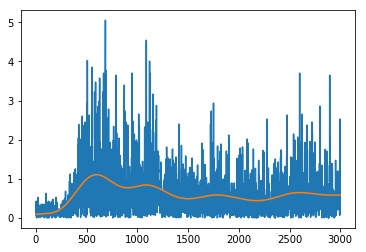

In [286]:
df_features = dataset.iloc[:,:3000].copy()
df_labels = dataset.iloc[:, 3001]

df_features = abs_val_filter(df_features)
smoothed_emg_df = butterworth_low_pass_filter(df_features.to_numpy(),
                                             frequency=5000,
                                             lp_filter=10)
plt.plot(df_features.to_numpy()[0])
plt.plot(smoothed_emg_df[0])

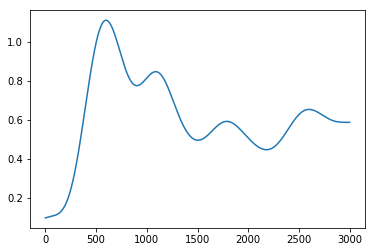

In [282]:
plt.plot(smoothed_emg_df[0])

In [283]:
""" Split EMG dataset into training and testing
"""

X_train, X_test, y_train, y_test = train_test_split(smoothed_emg_df, 
                                                    df_labels, 
                                                    test_size=0.2, 
                                                    random_state=3)

In [284]:
""" SVM Classification Results
"""

clf = make_pipeline(StandardScaler(),
                    SVC(gamma='auto', 
                        degree=2))
clf.fit(X_train, y_train)

svm_labels = clf.predict(X_test)

(svm_labels == y_test).value_counts()/len(X_test)

False    0.636111
True     0.363889
Name: label, dtype: float64

In [259]:
""" KMeans unsupervised learning
"""

kmeans = KMeans(n_clusters=len(LABELS), 
                random_state=0).fit(X_train)

kmeans.labels_
predicted_labels = kmeans.predict(X_test)
predicted_labels

array([5, 0, 0, 0, 3, 2, 0, 3, 5, 0, 0, 5, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0,
       5, 3, 3, 3, 0, 4, 4, 0, 3, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 3, 3, 5, 0, 4, 5, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 1, 0, 3, 0,
       0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 3, 3, 3, 0, 1, 0, 0, 4, 0, 3,
       0, 0, 0, 0, 3, 0, 0, 3, 3, 0, 3, 0, 0, 0, 0, 1, 4, 0, 3, 5, 0, 4,
       0, 0, 3, 0, 4, 0, 0, 4, 3, 3, 3, 1, 0, 3, 0, 0, 0, 3, 2, 0, 3, 3,
       5, 1, 1, 3, 3, 0, 0, 3, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 1, 3, 0,
       0, 3, 3, 0, 3, 0, 0, 3, 0, 5, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 5,
       0, 0, 0, 0, 0, 3, 3, 3, 0, 3, 3, 0, 0, 0, 1, 0, 0, 4, 3, 3, 1, 0,
       3, 5, 0, 3, 3, 0, 0, 0, 3, 0, 3, 0, 0, 5, 2, 3, 0, 3, 5, 5, 0, 3,
       3, 3, 3, 4, 1, 0, 0, 1, 1, 0, 0, 0, 3, 0, 5, 0, 3, 0, 0, 3, 5, 0,
       3, 5, 3, 0, 0, 4, 0, 0, 3, 1, 3, 3, 0, 0, 0, 4, 3, 3, 0, 0, 0, 0,
       0, 0, 0, 3, 3, 3, 0, 1, 0, 1, 0, 0, 0, 3, 0, 3, 3, 0, 0, 0, 3, 0,
       0, 0, 4, 0, 0, 0, 5, 0, 0, 4, 4, 0, 0, 3, 0,